## Building a Quant Strategy from Scratch
This notebook builds a simple linear strategy using daily values for Advanced Micro Devices (AMD).

### Set Up

In [1]:
# Data and analysis libraries
import polars as pl                     # Fast dataframes for financial data
import numpy as np                      # Numerical computing library
import random

# Machine learning libraries  
import torch                            # PyTorch framework
import torch.nn as nn                   # Neural network modules
import torch.optim as optim             # Optimization algorithms

# Visualization and 
import altair as alt
import matplotlib.pyplot as plt

In [2]:
# Set seed to control outputs
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seed(42)

In [3]:
ticker = 'AMD'
timestep = 1
sharpe_annualisation_factor = np.sqrt(252/timestep) # to calculate SR later

In [36]:
ts = pl.read_csv(f"data/{ticker}_1d_ohlcv.csv")
ts = ts.with_columns(
    pl.col("date").str.to_date("%d/%m/%y")
).sort('date')
ts.head()

date,open,high,low,close,volume
date,f64,f64,f64,f64,i64
2015-11-23,2.22,2.24,2.18,2.22,4862634
2015-11-24,2.2,2.4,2.17,2.34,15858610
2015-11-25,2.36,2.4,2.31,2.38,6915033
2015-11-27,2.37,2.38,2.32,2.33,2606577
2015-11-30,2.34,2.37,2.25,2.36,9915362


### Exploratory Data Analysis

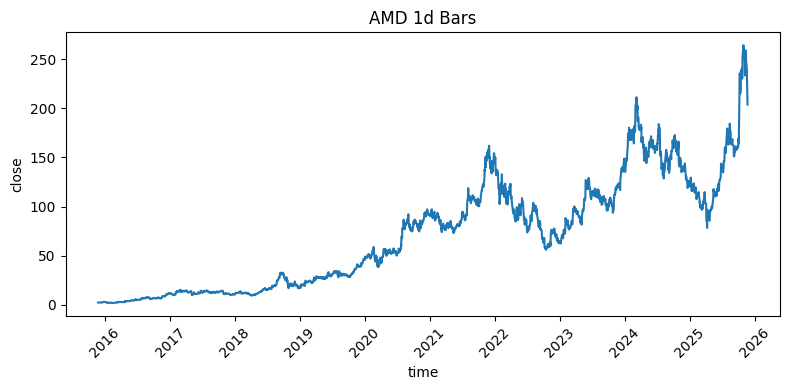

In [37]:
plt.figure(figsize=(8,4))
plt.plot(ts['date'], ts['close'])
plt.title(f'{ticker} 1d Bars')
plt.xlabel('time')
plt.ylabel('close')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  

In [38]:
alt.data_transformers.enable("vegafusion")
alt.Chart(ts).mark_line(tooltip=True).encode(
    x='date',
    y='close'
).properties(
    width=800,
    height=400,
    title=f"{ticker} 1d close"
).configure_scale(zero=False).add_params(
    alt.selection_interval(bind='scales', encodings=['x']),
    alt.selection_interval(bind='scales', encodings=['y'])
) 

alt.Chart(...)

##### Modelling Returns

In [39]:
# Want to model returns over raw values
ts = ts.with_columns((pl.col('close')/pl.col('close').shift(timestep)).log().alias('close_log_return'))

In [40]:
# Distribution of close values
alt.Chart(ts).mark_bar().encode(
        alt.X(f'{'close'}:Q', bin=alt.Bin(maxbins=50)),
        y='count()'
    ).properties(
        width=600,
        height=400,
        title='Distribution of close'
    ).configure_scale(zero=False).add_params(
        alt.selection_interval(bind='scales')
)    

alt.Chart(...)

In [41]:
# Distribution of close log return values
alt.Chart(ts).mark_bar().encode(
        alt.X(f'{'close_log_return'}:Q', bin=alt.Bin(maxbins=50)),
        y='count()'
    ).properties(
        width=600,
        height=400,
        title='Distribution of close_log_return'
    ).configure_scale(zero=False).add_params(
        alt.selection_interval(bind='scales')
)    

alt.Chart(...)

### Modelling

##### Feature Engineering

In [42]:
# Using lagged returns to predict future returns
target = 'close_log_return'
lr = pl.col(target)
ts = ts.with_columns(
    lr.shift(timestep * 1).alias(f'{target}_lag_1'),
    lr.shift(timestep * 2).alias(f'{target}_lag_2'),
    lr.shift(timestep * 3).alias(f'{target}_lag_3'),
    lr.shift(timestep * 4).alias(f'{target}_lag_4'),
)
ts.head(5)


date,open,high,low,close,volume,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
date,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64
2015-11-23,2.22,2.24,2.18,2.22,4862634,null,null,null,null,null
2015-11-24,2.2,2.4,2.17,2.34,15858610,0.052644,null,null,null,null
2015-11-25,2.36,2.4,2.31,2.38,6915033,0.01695,0.052644,null,null,null
2015-11-27,2.37,2.38,2.32,2.33,2606577,-0.021232,0.01695,0.052644,null,null
2015-11-30,2.34,2.37,2.25,2.36,9915362,0.012793,-0.021232,0.01695,0.052644,null


In [43]:
# Remove null values
ts = ts.drop_nulls()
ts.head(1)

date,open,high,low,close,volume,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
date,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64
2015-12-01,2.36,2.37,2.31,2.34,5646342,-0.008511,0.012793,-0.021232,0.01695,0.052644


##### Building the Model

In [44]:
# y = wx + b
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)

    def forward(self, x):
        return self.linear(x)

In [45]:
# Get model info
no_features = 1
model = LinearModel(no_features)
model_name = 'Linear Model'

# Count all parameters in the model
total_params = sum(p.numel() for p in model.parameters())

# Count only parameters that will be updated during training
trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)

# Print formatted model information
print(f"\n{'='*60}")
print(f"{model_name}")
print(f"{'='*60}")
print(f"\nArchitecture:")
print(f"  {model}")
print(f"\nParameter Count:")
print(f"  Total parameters:      {total_params:,}")
print(f"  Trainable parameters:  {trainable_params:,}")

# Warn if some parameters are frozen
if total_params != trainable_params:
    frozen_params = total_params - trainable_params
    print(f"  Frozen parameters:     {frozen_params:,}")
    print(f"\n  ⚠️  Note: {frozen_params:,} parameters are frozen")

print(f"{'='*60}\n")


Linear Model

Architecture:
  LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

Parameter Count:
  Total parameters:      2
  Trainable parameters:  2



##### Train Test Split

In [46]:
features = ['close_log_return_lag_1', 'close_log_return_lag_2'] # naive approach
target = 'close_log_return'
test_size = 0.25
split_idx = int(len(ts) * (1-test_size))
ts_train, ts_test = ts[:split_idx], ts[split_idx:]

In [47]:
# ROI if we buy and hold during test period (a good strategy will have over ~19% returns)
net_return = ts_test.with_columns(pl.col('close_log_return').cum_sum().alias('close_log_return_cum_sum'))['close_log_return_cum_sum'][-1]
np.exp(net_return)

np.float64(1.884757676655568)

In [48]:
# Convert to tensors
X_train = torch.tensor(ts_train[features].to_numpy(), dtype=torch.float32)
y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32).reshape(-1, 1) 

X_test = torch.tensor(ts_test[features].to_numpy(), dtype=torch.float32)
y_test = torch.tensor(ts_test[target].to_numpy(), dtype=torch.float32).reshape(-1, 1) # could technically just assign to list[target]

##### Batch Gradient Descent

In [49]:
model = LinearModel(len(features))

# Hyperparameters
no_epochs = 50 * 5
lr = 0.01
criterion = nn.MSELoss() # Loss Function
optimiser = optim.Adam(model.parameters(), lr = lr) # Optimiser

for epoch in range(no_epochs):
    # forward pass
    y_hat = model(X_train)
    loss = criterion(y_hat, y_train)

    # backward pass
    optimiser.zero_grad()   # 1. clear old gradients
    loss.backward()         # 2. compute new gradients
    optimiser.step()        # 3. update weights

    # check for improvement
    train_loss = loss.item()

    # logging
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{no_epochs}], Loss: {train_loss:.6f}")

print("\nLearned parameters")

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}:\n{param.data.numpy()}")

# Evaluation
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_loss = criterion(y_hat, y_test)
    print(f"\nTest Loss: {test_loss.item():.6f}, Train Loss: {train_loss:.6f}")

Epoch [50/250], Loss: 0.001483
Epoch [100/250], Loss: 0.001422
Epoch [150/250], Loss: 0.001422
Epoch [200/250], Loss: 0.001422
Epoch [250/250], Loss: 0.001422

Learned parameters
linear.weight:
[[-0.0556579   0.05483802]]
linear.bias:
[0.00203538]

Test Loss: 0.001073, Train Loss: 0.001422


##### Trading Performance

In [50]:
trade_results = pl.DataFrame({
    'y_hat': y_hat.squeeze(),
    'y': y_test.squeeze()
}).with_columns(
    (pl.col('y_hat').sign()==pl.col('y').sign()).alias('is_won'),  # Correct prediction
    pl.col('y_hat').sign().alias('signal'),                        # Signal generated
).with_columns(
    (pl.col('signal') * pl.col('y')).alias('trade_log_return')     # Return
).with_columns(
    pl.col('trade_log_return').cum_sum().alias('equity_curve')     # Cumulative Net Return
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve
f32,f32,bool,f32,f32,f32
0.003092,0.001386,true,1.0,0.001386,0.001386
0.002019,0.105776,true,1.0,0.105776,0.107162
-0.003776,0.054019,false,-1.0,-0.054019,0.053143
0.004829,-0.013952,false,1.0,-0.013952,0.039191
0.005774,-0.058009,false,1.0,-0.058009,-0.018817
…,…,…,…,…,…
-0.000071,-0.025816,true,-1.0,0.025816,1.444497
0.003217,-0.043464,false,1.0,-0.043464,1.401033
0.003039,-0.029704,false,1.0,-0.029704,1.371328


In [51]:
trade_results = trade_results.with_columns(pl.arange(0, pl.len()).alias("row_id"))

alt.Chart(trade_results).mark_line(tooltip=True).encode(
    x='row_id',
    y='equity_curve'
).properties(
    width=800,
    height=400,
    title=f"{ticker} 1d equity curve"
).configure_scale(zero=False).add_params(
    alt.selection_interval(bind='scales', encodings=['x']),
    alt.selection_interval(bind='scales', encodings=['y'])
) 

alt.Chart(...)

In [52]:
# Summary Statistics
trade_results = trade_results.with_columns((pl.col('equity_curve')-pl.col('equity_curve').cum_max()).alias('drawdown_log'))
max_drawdown_log = trade_results['drawdown_log'].min()
print("Max Drawdown (%):", np.exp(max_drawdown_log)-1)

win_rate = trade_results['is_won'].mean()
print("Win Rate:", win_rate)

avg_win = trade_results.filter(pl.col('is_won')==True)['trade_log_return'].mean()
avg_loss = trade_results.filter(pl.col('is_won')==False)['trade_log_return'].mean()
ev = win_rate * avg_win + (1 - win_rate) * avg_loss
print("Expected Value (per trade):", ev) 

total_log_return = trade_results['trade_log_return'].sum()
print("Return Rate:", np.exp(total_log_return)) # outperforms buy and hold

sd = trade_results['trade_log_return'].std()
print("Sharpe Ratio:", ev / sd * sharpe_annualisation_factor)

Max Drawdown (%): -0.42283945730156913
Win Rate: 0.5191082802547771
Expected Value (per trade): 0.0020362012295385527
Return Rate: 3.5920908612631197
Sharpe Ratio: 0.9854149647793333


##### Adding Transaction Fees

In [53]:
maker_fee = 0.0001
taker_fee = 0.0002

roundtrip_fee_log = np.log(1 - 2 * taker_fee) # could reduce this by adding logic to keep trade open if signal is same

trade_results = trade_results.with_columns(pl.lit(roundtrip_fee_log).alias('tx_fee_log'))
trade_results = trade_results.with_columns((pl.col('trade_log_return') + pl.col('tx_fee_log')).alias('trade_log_return_net'))
trade_results = trade_results.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net'))

In [54]:
alt.Chart(trade_results).mark_line(tooltip=True).encode(
    x='row_id',
    y='equity_curve_net'
).properties(
    width=800,
    height=400,
    title=f"{ticker} 1d equity curve net"
).configure_scale(zero=False).add_params(
    alt.selection_interval(bind='scales', encodings=['x']),
    alt.selection_interval(bind='scales', encodings=['y'])
) 

alt.Chart(...)

In [ ]:
# Summary Statistics
trade_results = trade_results.with_columns((pl.col('equity_curve_net')-pl.col('equity_curve_net').cum_max()).alias('drawdown_log_net'))
max_drawdown_log = trade_results['drawdown_log_net'].min()
print("Max Drawdown (%):", np.exp(max_drawdown_log)-1) # significant drawdown

win_rate = trade_results['is_won'].mean()
print("Win Rate:", win_rate)

avg_win = trade_results.filter(pl.col('is_won')==True)['trade_log_return_net'].mean()
avg_loss = trade_results.filter(pl.col('is_won')==False)['trade_log_return_net'].mean()
ev = win_rate * avg_win + (1 - win_rate) * avg_loss
print("Expected Value (per trade):", ev) 

total_log_return = trade_results['trade_log_return_net'].sum()
print("Return Rate:", np.exp(total_log_return)) # still outperforms buy and hold

sd = trade_results['trade_log_return_net'].std()
print("Sharpe Ratio:", ev / sd * sharpe_annualisation_factor)

Max Drawdown (%): -0.45055392060940136
Win Rate: 0.5191082802547771
Expected Value (per trade): 0.0016361212081988496
Return Rate: 2.7940275431477963
Sharpe Ratio: 0.7917971409990883


##### Position Frequency

In [57]:
trade_results.filter(pl.col('signal')==1).sum()[['is_won', 'signal']]

is_won,signal
u32,f32
258,502.0


In [58]:
trade_results.filter(pl.col('signal')==-1).sum()[['is_won', 'signal']]

is_won,signal
u32,f32
68,-126.0


Majority of positions are long (80%). One simple idea could be to set the model to be long by default, and to only trade when short signals appear, considering the higher win rate and redundancy of paying fees for a stock that has generally been long.

### Tuning / Optimisation
Now, try different combinations of features and parameters.